# Summary
- [Data](#Data)
- [Model](#Model)
- [Training](#Training)
- [Evaluation](#Evaluation)
- [Visualization](#Visualization)

# Dependencies

In [1]:
#visualization
import matplotlib.pyplot as plt
#math tools
import numpy as np
from sklearn.preprocessing import normalize
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler
from scipy.signal import resample
from scipy.signal import decimate
#machine learning
import torch
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")
print(device)
#utils
from time import time
from os.path import join
from os import listdir

cuda


# Utils

In [2]:
measure2index={"y-coordinate":0,"x-coordinate":1,"timestamp":2, "button_status":3,"tilt":4, "elevation":5,"pressure":6}
index2measure=list(measure2index.keys())

task2index={"spiral":0,"l":1,"le":2 ,"les":3,"lektorka" :4,"porovnat":5,"nepopadnout":6, "tram":7}
index2task=list(task2index.keys())

In [3]:
def timeSince(since):
    now = time()
    s = now - since
    m = np.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [121]:
def return_results(train_metrics,valid_metrics,early_stopping):
    train_metrics,valid_metrics=np.asarray(train_metrics),np.asarray(valid_metrics)
    
    results="{} ; {} ; {} ; {} ; {} ; {} ; {} ; {} ; {} ; {:.2f} (+ {:.2f}) ; {:.2f} (+ {:.2f}) ".format(
    index2task[task],downsampling_factor,learning_rate,hidden_size,num_layers,bidirectional,carry_over,dropout,clip,
    np.mean(early_stopping),np.std(early_stopping),np.mean(train_metrics[:,1]),np.std(train_metrics[:,1]))
    
    valid_metrics=valid_metrics.T
    for metric in valid_metrics[1:]:#don't care about the loss
        mean,std=np.mean(metric),np.std(metric)
        results+="; {:.2f} (+ {:.2f}) ".format(mean,std)
    return results

In [169]:
def confusion_matrix(y_true,y_pred):
    tn, fp, fn, tp=0,0,0,0
    false_i=[]
    for i, (target, pred) in enumerate(list(zip(y_true,y_pred))):
        if target==0:#condition negative
            if pred==0:
                tn+=1
            else:
                fp+=1
                false_i.append(i)
        else:#condition positive
            if pred==0:
                fn+=1
                false_i.append(i)
            else:
                tp+=1
    return tn, fp, fn, tp, false_i

# Data
## Loading

In [4]:
data_path=join("..","PaHaW","PaHaW_public")#/00026/00026__1_1.svc"
folder_path=listdir(data_path)
folder_path.sort()

In [5]:
meta_path=join("..","PaHaW","corpus_PaHaW.csv")
meta_data=[]
with open(meta_path) as file:
    for line in file.readlines():
        meta_data.append(line.split(";"))
meta_data.pop(0)
meta_data=np.asarray(meta_data)
labels=[1 if i =="ON" else 0 for i in meta_data[:,4]]


In [6]:
task_path=listdir(join(data_path,folder_path[46]))
task_path.sort()

Subjects 46 (control),
60 (PD) and
66 (control) didn't perform the spiral !


In [7]:
raw=[]
for folder in folder_path:
    subject=[]
    task_path=listdir(join(data_path,folder))
    task_path.sort()
    if len(task_path)!=8:#subject didn't perform the spiral
        subject.append([])#add an empty array so that all tasks are on the same column number
    for task in task_path:
        measures=[]
        path=join(data_path,folder,task)
        with open(path) as file:
            for line in file.readlines():
                measures.append(line.split())
            measures.pop(0)
        subject.append(measures)
    raw.append(subject)

In [8]:
print("(75 subjects, 8 tasks, X task duration*200, 7 recorded signals)")
print(len(raw),len(raw[0]),len(raw[0][0]),len(raw[0][0][0]))

(75 subjects, 8 tasks, X task duration*200, 7 recorded signals)
75 8 1772 7


The task sequence is in average **2286** &rarr; task duration is in average 11.4s  

task | duration | duration std
--|--|--
spiral | 2758.75 | 2267.76 
l | 1668.01 | 724.14 
le | 1984.16 | 999.61 
les | 2305.01 | 1095.54 
lektorka | 2608.48 | 1333.76  
porovnat | 2315.08 | 1033.69 
nepopadnout | 1469.29 | 650.65 
tram | 3086.13 | 1158.81

## Exploration

spiral
l
le
les
lektorka
porovnat
nepopadnout
tram


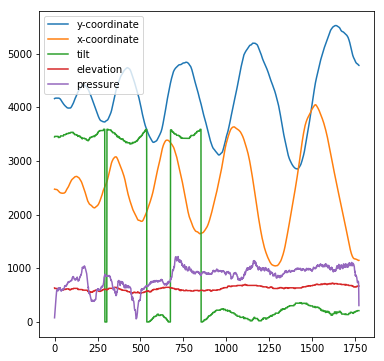

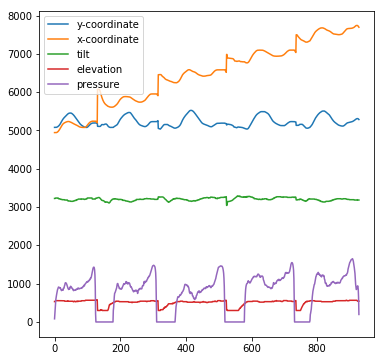

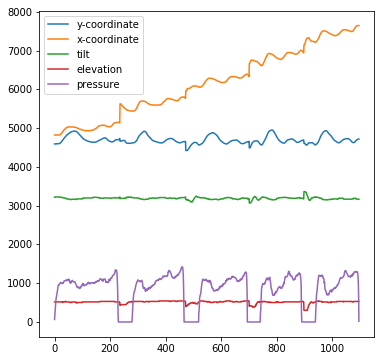

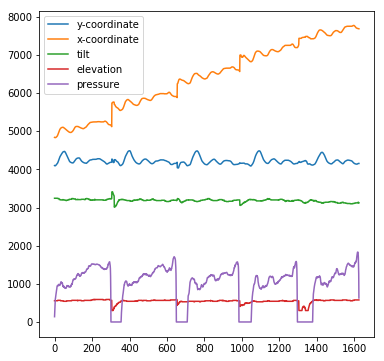

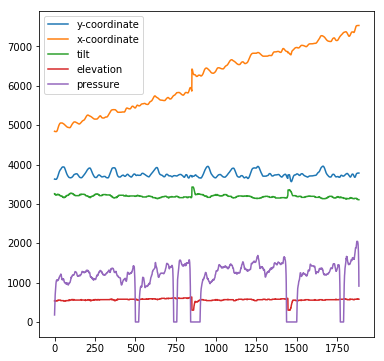

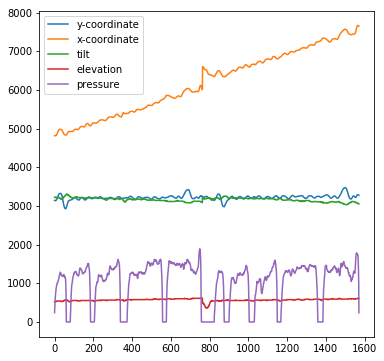

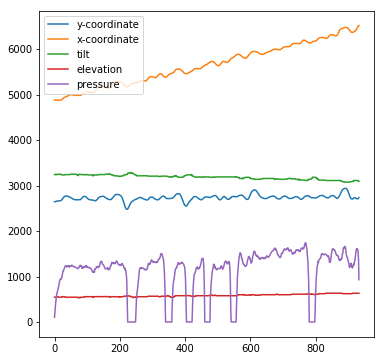

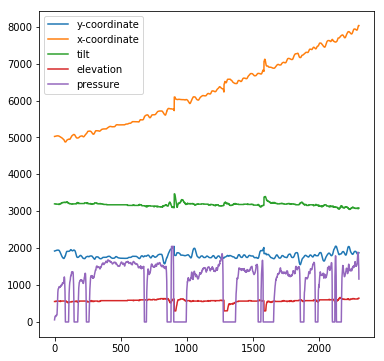

In [572]:
%matplotlib inline
subject_index=0#np.random.randint(0,len(labels))
for j in range(8):
    print(index2task[j])
    task=np.asarray(raw[subject_index][j],dtype=int)
    if task.size!=0:
        plt.figure(figsize=(6,6))
        for i in [0,1,4,5,6]:
            plt.plot(task[:,i],label=index2measure[i])
            plt.legend()
    else:
        print("Subject n° {} didn't perform {} task".format(subject_index,index2task[j]))
    

In [264]:
def DetectPause(time):
    """looks through the difference between 2 consecutives points of the timestamp of a task
    to detect if there's pauses during the recording
    
    Returns :
    - True if a Pause was detected
    - False if not"""
    timediff = [time[t+1]-time[t] for t in range(len(time)-1)]
    #print(timediff)
    for t in timediff:
        if t!=7 and t!=8:
            return True
    return False

After investigation I found that most of the exams contained (really) small pauses.  
Therefore, the timestamp measure might be useful so the model has a sense of these pauses.  

spiral
l
le
les
lektorka
porovnat
nepopadnout
tram


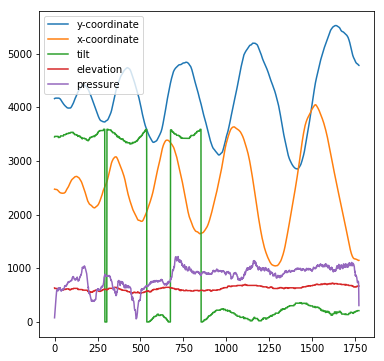

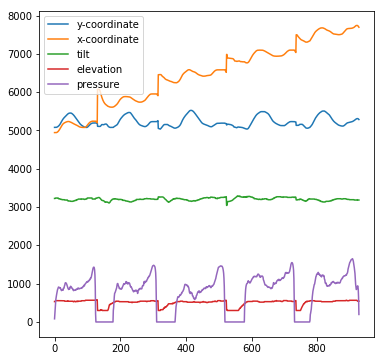

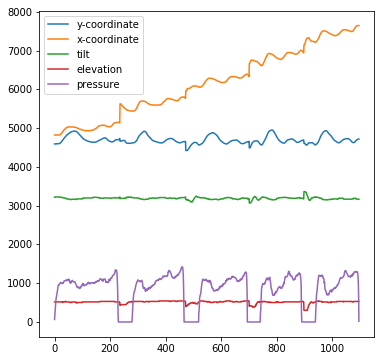

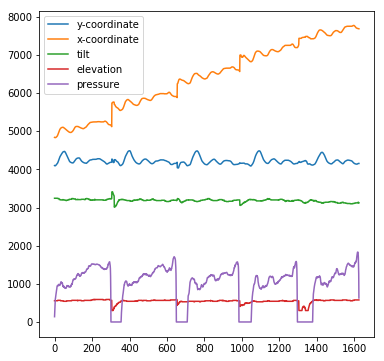

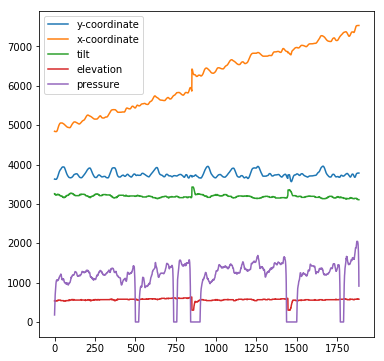

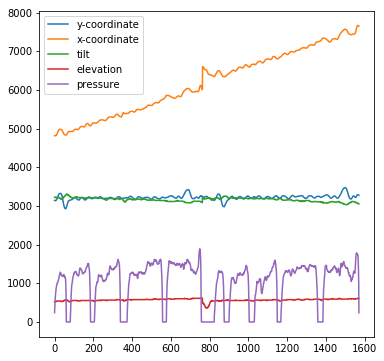

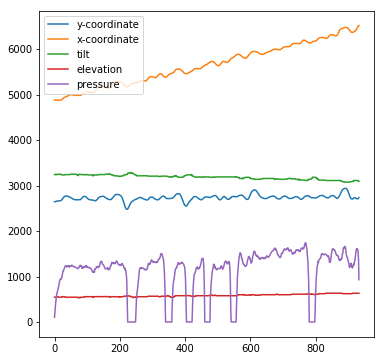

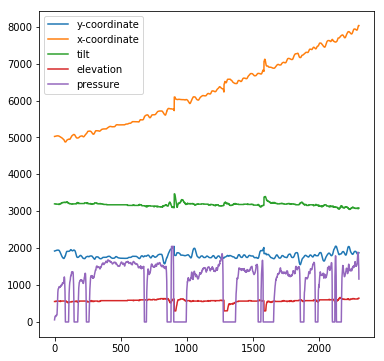

In [222]:
%matplotlib inline
subject_index=0#np.random.randint(0,len(labels))
for j in range(8):
    print(index2task[j])
    task=np.asarray(raw[subject_index][j],dtype=int)
    if task.size!=0:
        plt.figure(figsize=(6,6))
        for i in [0,1,4,5,6]:
            plt.plot(task[:,i],label=index2measure[i])
            plt.legend()
    else:
        print("Subject n° {} didn't perform {} task".format(subject_index,index2task[j]))
    

0
spiral
l
le
les
lektorka
porovnat
nepopadnout
tram


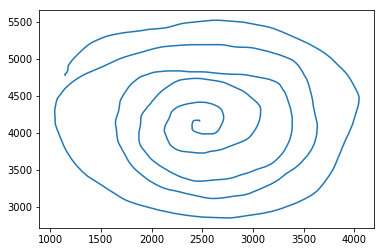

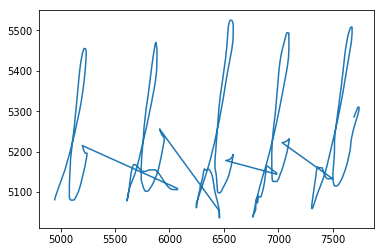

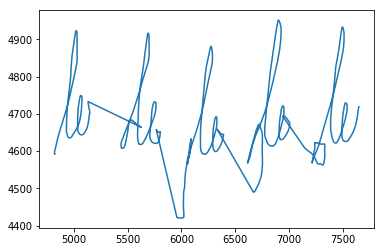

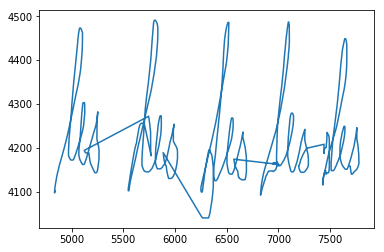

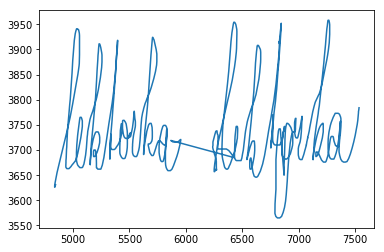

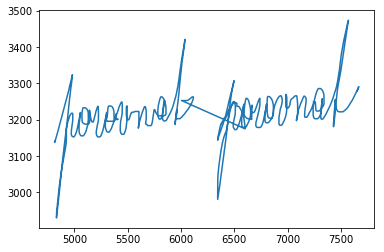

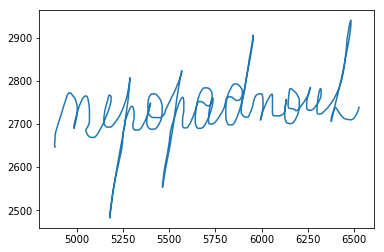

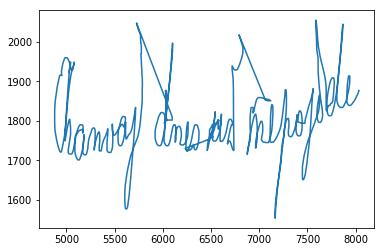

In [204]:
%matplotlib inline
subject_index=0#np.random.randint(0,len(labels))
print(subject_index)
for j in range(8):
    print(index2task[j])
    task=np.asarray(raw[subject_index][j],dtype=int)
    if task.size!=0:
        plt.figure()
        plt.plot(task[:,1],task[:,0])
    else:
        print("Subject n° {} didn't perform {} task".format(subject_index,index2task[j]))

## Preprocessing


### Standardize
along axis 0 in order to normalize all the measures independently (i.e. not all time steps independently)  
Cf. Report #4 : it's better to standardize than to normalize !

0
spiral
l
le
les
lektorka
porovnat
nepopadnout
tram


/home/paul/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/home/paul/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/home/paul/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/home/paul/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/home/paul/anaconda3/envs/pytorch/lib/python3.7/

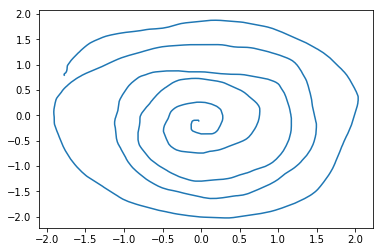

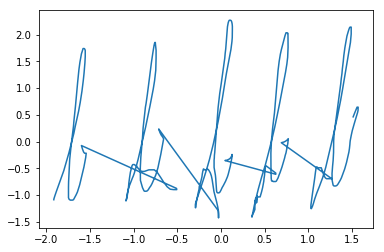

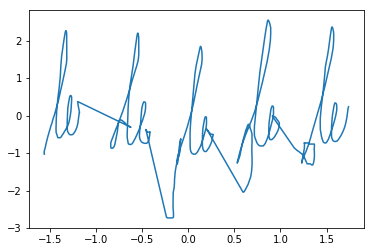

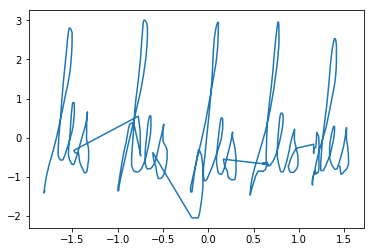

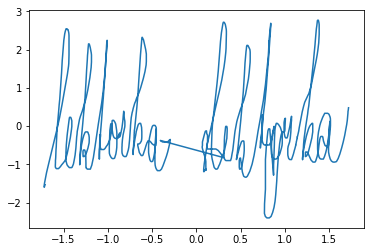

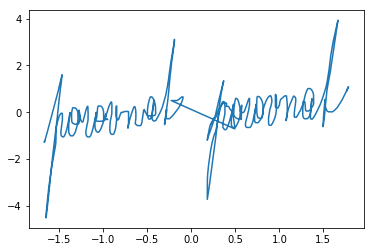

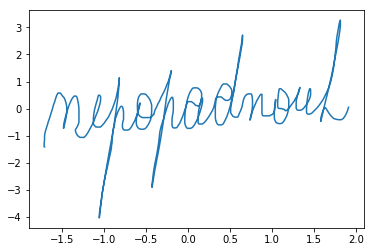

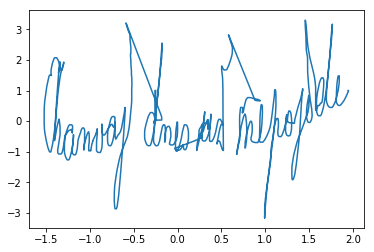

In [298]:
%matplotlib inline
subject_index=0#np.random.randint(0,len(labels))
print(subject_index)
for j in range(8):
    print(index2task[j])
    task=scale(np.asarray(raw[subject_index][j],dtype=int),axis=0)
    if task.size!=0:
        plt.figure()
        plt.plot(task[:,1],task[:,0])
    else:
        print("Subject n° {} didn't perform {} task".format(subject_index,index2task[j]))

### Dowsampling
downsamples using [SciPy's decimate](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.decimate.html).  
After experiment [SciPy's resample](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.resample.html) is ineffective as the signal is not periodic

/home/paul/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


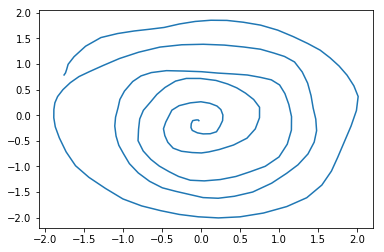

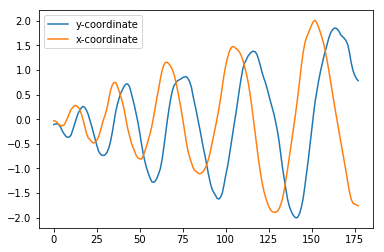

In [343]:
downsampling_factor=10#the sequence will be 10 times shorter !
task=scale(np.asarray(raw[0][0],dtype=int),axis=0)
sparse_spiral=decimate(task,downsampling_factor,axis=0)
%matplotlib inline
plt.figure()
plt.plot(sparse_spiral[:,1],sparse_spiral[:,0])
plt.figure()
for i in [0,1]:
    plt.plot(sparse_spiral[:,i],label=index2measure[i])
    plt.legend()


## Task selection

In [170]:
task_name=index2task[0]
task=task2index[task_name]
print(task,task_name)

0 spiral


In [171]:
data=[raw[i][task]  for i,subject in enumerate(raw) if len(raw[i][task])!=0]#discard the subjects that didn't perform spiral

In [172]:
targets= [labels[i]  for i,subject in enumerate(raw) if len(raw[i][0])!=0]
#for multi class #
#spiral_targets=[target[i]  for i,subject in enumerate(raw) if len(raw[i][0])!=0]
#discard the subjects that didn't perform spiral

the lengths of the spirals is extremely variable :  
mean, std :  
(2873.6944444444443, 2242.0327745578024)

### Scale then downsample

In [173]:
import warnings
from sklearn.exceptions import DataConversionWarning
#the scale function will implicitly convert the data from int to float, thus yielding len(data) warnings
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
downsampling_factor=1
for i,subject in enumerate(data):
    if downsampling_factor==1:#don't downsample
        data[i]=scale(np.asarray(subject,dtype=int),axis=0)
    else:
        data[i]=decimate(
            scale(np.asarray(subject,dtype=int),axis=0),#scale first
                  downsampling_factor,axis=0)#then downsample
    
print(len(data),len(targets),len(data[0]))

72 72 1772


### Data split
In order to provide for a meaningful comparison with works from Drotar et al. and Moetesum et al. we will evaluate our results using a 10-fold cross validation  
The actual split is done before [Training](#Training)

# Model
- [**Pytorch LSTM doc**](https://pytorch.org/docs/stable/nn.html#torch.nn.LSTM)
- [**Pytorch Linear doc**](https://pytorch.org/docs/stable/nn.html#torch.nn.Linear)
- [**Pytorch Binary Cross Entropy loss (BCELoss) doc**](https://pytorch.org/docs/stable/nn.html#torch.nn.BCELoss)

## Definition
Cf. Report #4 for details about the architecture of the model

In [174]:
class Model(torch.nn.Module):
    """
    Args:
        #Vanilla LSTM
        input_size: The number of expected features in the input `x`
        hidden_size: The number of features in the hidden state `h`
        num_layers: Number of recurrent layers. E.g., setting ``num_layers=2``
            would mean stacking two LSTMs together to form a `stacked LSTM`,
            with the second LSTM taking in outputs of the first LSTM and
            computing the final results. Default: 1
        bias: If ``False``, then the layer does not use bias weights `b_ih` and `b_hh`.
            Default: ``True``
        batch_first: If ``True``, then the input and output tensors are provided
            as (batch, seq, feature). Default: ``False``
        dropout: If non-zero, introduces a `Dropout` layer on the outputs of each
            LSTM layer except the last layer, with dropout probability equal to
            :attr:`dropout`. Default: 0
        bidirectional: If ``True``, becomes a bidirectional LSTM. Default: ``False``
        
        #our model
        batch_size : default : 1
        output_size : default : 1
    """
    def __init__(self, input_size, hidden_size,num_layers=1, bias=True,batch_first=False,
                 dropout=0,bidirectional=False, batch_size=1, output_size=1):
        super(Model, self).__init__()
        #Vanilla LSTM
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bias=bias
        self.batch_first=batch_first
        self.dropout=dropout
        self.bidirectional=bidirectional
        #our model
        self.batch_size = batch_size
        self.output_size = output_size

        # Define the LSTM layer
        self.encoder = torch.nn.LSTM(self.input_size, self.hidden_size, self.num_layers,self.bias,self.batch_first,
                            self.dropout,self.bidirectional)
        
        #define the dropout layer
        self.dropout_layer=torch.nn.Dropout(self.dropout)

        # Define the decoder layer
        self.linear = torch.nn.Linear(self.hidden_size, self.output_size)
        self.sigmoid = torch.nn.Sigmoid()
                
    def forward(self, input):
        # Forward pass through LSTM layer
        # shape of encoder_out: (seq_len, batch, num_directions * hidden_size)
        # shape of self.hidden: (h_n, c_n), where hidden state h_n and cell state c_n both 
        # have shape (num_layers * num_directions, batch, hidden_size).
        encoder_out, self.hidden = self.encoder(input)
        #print(encoder_out.shape)
        
        if self.bidirectional:
            #sums the outputs : direction left-right and direction right-left
            # encoder_out shape should now be (seq_len, batch,hidden_size)
            encoder_out = encoder_out[: ,: ,: self.hidden_size] + encoder_out[: , :, self.hidden_size: ]
        
        # Only take the output from the final timestep
        drop=self.dropout_layer(encoder_out[-1])
        y_pred = self.linear(drop)
        y_pred = self.sigmoid(y_pred)
        return y_pred.squeeze(0)
    
    def init_hidden(self):
        """h_0 of shape (num_layers * num_directions, batch, hidden_size): 
        tensor containing the initial hidden state for each element in the batch. 
        If the RNN is bidirectional, num_directions should be 2, else it should be 1.

        c_0 of shape (num_layers * num_directions, batch, hidden_size): 
        tensor containing the initial cell state for each element in the batch.
        
        The hidden state is modified in place.
        """
        num_directions=1
        if self.bidirectional:
            num_directions=2
            
        self.hidden=torch.zeros(self.num_layers*num_directions, self.batch_size, self.hidden_size),
        torch.zeros(self.num_layers*num_directions, self.batch_size, self.hidden_size)
    
    def init_forget_bias(self):
        """Following advices of Jozefowicz et al. 2015,
        we initialize the bias of the forget gate to a large value such as 1
        In PyTorch, the forget gate bias is stored as b_hf in bias_hh_l[k] : 
        the learnable hidden-hidden bias of the kth layer (b_hi|b_hf|b_hg|b_ho), of shape (4*hidden_size).
        So b_hf == bias_hh_lk[hidden_size:2*hidden_size]
        
        The weights are modified in-place, like init_hidden(self).
        """
        gen=self.modules()
        _=next(gen)#model summary : don't care about it
        lstm=next(gen)
        if not isinstance(lstm,torch.nn.LSTM):
            raise NotImplementedError("the encoder should be an LSTM and should be the first module of the model")
        
        with torch.no_grad():#so the optimizer doesn't know about this ;)
            lstm.bias_hh_l0[hidden_size:2*hidden_size]=torch.ones(lstm.hidden_size)
            if lstm.bidirectional:
                lstm.bias_hh_l0_reverse[hidden_size:2*hidden_size]=torch.ones(lstm.hidden_size)
            if lstm.num_layers > 1:
                lstm.bias_hh_l1[hidden_size:2*hidden_size]=torch.ones(lstm.hidden_size)
                if lstm.bidirectional:
                    lstm.bias_hh_l1_reverse[hidden_size:2*hidden_size]=torch.ones(lstm.hidden_size)
            if lstm.num_layers > 2:
                lstm.bias_hh_l2[hidden_size:2*hidden_size]=torch.ones(lstm.hidden_size)    
                if lstm.bidirectional:
                    lstm.bias_hh_l2_reverse[hidden_size:2*hidden_size]=torch.ones(lstm.hidden_size)
            if lstm.num_layers>3:
                raise NotImplementedError("you can only have 3 layers for now")
                
    def count_params(self):
        """returns (total n° of parameters, n° of trainable parameters)"""
        total_params = sum(p.numel() for p in self.parameters())
        trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        return total_params, trainable_params


# Training
## step

In [175]:
def step(input, target, model, optimizer, loss_fn, batch_size,clip=None,validation = False):
    if not validation:
        # Zero gradients
        optimizer.zero_grad()    
        
    # Set device options
    input=input.to(device)
    target=target.to(device)
        
    #forward pass
    output=model(input)
    
    # Compute loss
    loss = loss_fn(output, target)
    
    
    
    if not validation:
        # Perform backpropagation
        loss.backward()
        if clip is not None:
            #clip gradients to previent exploding
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        # Adjust model weights
        optimizer.step()
        
        # carry over regularization
        if np.random.rand() <carry_over:
            model.init_hidden()
    
    return loss.item(), output.item()

## epoch

In [176]:
def epoch(data,targets, model, optimizer, loss_fn, batch_size, random_index,clip=None,validation=False):
    losses=[]
    predictions=[]
    condition_targets=[]
    
    for index in random_index:
        condition_targets.append(targets[index])
        #numpy to tensor
        subject=torch.Tensor(data[index]).unsqueeze(1)#add batch dimension
        #truncate then gives shape (channels, seq_len) then add batch dimension
        #subject=torch.Tensor(data[index][0:shortest_spiral]).t().unsqueeze(0)
        
        target=torch.Tensor([targets[index]])        
        loss, prediction =step(subject,target, model, optimizer, loss_fn, batch_size,clip,validation)
        predictions.append(round(prediction))
        losses.append(loss)
    
    #compute metrics
    #tn, fp, fn, tp = metrics.confusion_matrix(y_true=condition_targets,y_pred=predictions,labels=[0,1]).ravel()
    tn, fp, fn, tp, false_i = confusion_matrix(y_true=condition_targets,y_pred=predictions)
    false=[random_index[i] for i in false_i]
    accuracy= (tp+tn)/(tp+tn+fp+fn)
    sensitivity = tp/(tp+fn) if (tp+fn) != 0 else 0.0 #without condition positives the sensitivity should be 0
    specificity = tn/(tn+fp) if (tn+fp)!= 0 else 0.0 #idem
    ppv = tp/(tp+fp) if tp+fp != 0 else 0.0 #without predicted positives the ppv should be 0
    npv = tn/(tn+fn) if tn+fn !=0 else 0.0 #idem
    
    return [np.mean(losses),accuracy,sensitivity,specificity,ppv,npv],false

## Hyperparameters

In [181]:
learning_rate = 1e-3
hidden_size=50
num_layers=1
bidirectional=True
dropout=0.5
carry_over=0.0
clip=5.0#clipping value to clip the gradients norm : set to None if you don't want to clip

input_size=7#==len(index2measure)
bias=True
batch_first=False#we should unsqueeze(1) to add a batch dimension
batch_size=1
output_size=1#binary classif : 1 means PD, 0 means control

loss_fn=torch.nn.BCELoss()#Binary cross entropy

## 10 fold cross validation (early stopping)

In [ ]:
verbose=False
skf = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
cv_generator=skf.split(data,targets)
fold_train_metrics,fold_valid_metrics,fold_falses=[],[],[]
start = time()
np.random.seed(1)
save_to_print=""
fold=0
n_epochs=50#max n° of epochs the model will be trained to
patience = 10#n° of epochs without improvement during which the model will wait before stopping

for train_index,test_index in cv_generator:     
    train_metrics,valid_metrics,falses=[],[],[]
    
    torch.manual_seed(1)#random seed for weights init
    model=Model(input_size, hidden_size,num_layers, bias,batch_first,
                 dropout,bidirectional, batch_size, output_size)
    model.init_hidden()
    model.init_forget_bias()
    model=model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    if fold==0:        
        print("(total n° of parameters, n° of trainable parameters)\n",model.count_params())
        
    best_accuracy=0
    #best_loss=10000.0
    impatience=0
    for i in range(n_epochs):                
        to_print=""
        np.random.shuffle(train_index)
        np.random.shuffle(test_index)
        #training
        model.train()
        [loss,accuracy,sensitivity,specificity,ppv,npv],_=epoch(
        data, targets, model, optimizer, loss_fn, batch_size, train_index,clip,validation=False)
        train_metrics.append([loss,accuracy,sensitivity,specificity,ppv,npv])
        to_print+="\n\nfold n°{}, epoch n°{}, spent {}".format(fold,i,timeSince(start))
        to_print+="\nTRAINING : loss {:.3f}, accuracy {:.3f}".format(loss,accuracy)

        #validation
        model.eval()
        [loss,accuracy,sensitivity,specificity,ppv,npv],false=epoch(
            data, targets, model, optimizer, loss_fn, batch_size, test_index,validation=True)    
        valid_metrics.append([loss,accuracy,sensitivity,specificity,ppv,npv])
        falses.append(false)
        to_print+="\nVALIDATION : loss {:.3f}, accuracy {:.3f}, sensitivity  {:.3f}, specificity {:.3f}, ppv {:.3f}, npv {:.3f}".format(
            loss,accuracy,sensitivity,specificity,ppv,npv)      
        
        #patience update        
        if accuracy <= best_accuracy:#`<=` no improvement is considered bad !#loss>=best_loss:
            impatience+=1
        else:
            best_accuracy=accuracy #best_loss=loss#
            impatience=0
            
        if verbose:
            print(to_print)
        save_to_print+=to_print
       
        #early stopping
        if impatience >= patience:
            save_to_print+="\nEarly stopped."
            break     
            
    fold_train_metrics.append(train_metrics)
    fold_valid_metrics.append(valid_metrics)
    fold_falses.append(falses)
    fold+=1
if not verbose:
    print(save_to_print)

/home/paul/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/nn/modules/rnn.py:46: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


(total n° of parameters, n° of trainable parameters)
 (23651, 23651)


## 1 over 10 fold training (no early stopping)

In [63]:
skf = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
cv_generator=skf.split(data, targets)

fold=-1

In [64]:
verbose=False

fold+=1
train_metrics,valid_metrics=[],[]
train_index,test_index=next(cv_generator)
print(test_index)
print("fold n°",fold)
torch.manual_seed(1)
model=Model(input_size, hidden_size,num_layers, bias,batch_first,
                 dropout,bidirectional, batch_size, output_size)
model.init_hidden()
model.init_forget_bias()
model=model.to(device)
print("(total n° of parameters, n° of trainable parameters)\n",model.count_params())
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
"""#should unsquueze 0 to add batch dim
model=torch.nn.Sequential(
    torch.nn.Conv1d(7,7,1),
    torch.nn.Conv1d(7,7,1),
    torch.nn.MaxPool1d(1),    
    torch.nn.Conv1d(7,1,1),
    torch.nn.MaxPool1d(1),
    torch.nn.Linear(shortest_spiral,1),
    torch.nn.Sigmoid()    
)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(sum(p.numel() for p in model.parameters()))"""
save_to_print=""
start = time()
np.random.seed(1)


[ 3 25 41 43 58 63 65 69]
fold n° 0
673


In [65]:
for i in range(5):  
    to_print=""
    np.random.shuffle(train_index)
    np.random.shuffle(test_index)
    #training
    model.train()
    [loss,accuracy,sensitivity,specificity,ppv,npv],_=epoch(
        data, targets, model, optimizer, loss_fn, batch_size, train_index,clip,validation=False)
    train_metrics.append([loss,accuracy,sensitivity,specificity,ppv,npv])
    to_print+="\n\nfold n°{}, epoch n°{}, spent {}".format(fold,i,timeSince(start))
    to_print+="\nTRAINING : loss {:.3f}, accuracy {:.3f}".format(loss,accuracy)
    
    #validation
    model.eval()
    [loss,accuracy,sensitivity,specificity,ppv,npv],false=epoch(
        data, targets, model, optimizer, loss_fn, batch_size, test_index,validation=True)    
    valid_metrics.append([loss,accuracy,sensitivity,specificity,ppv,npv])
    falses.append(false)
    to_print+="\nVALIDATION : loss {:.3f}, accuracy {:.3f}, sensitivity  {:.3f}, specificity {:.3f}, ppv {:.3f}, npv {:.3f}".format(
        loss,accuracy,sensitivity,specificity,ppv,npv)
    
    if verbose:
        print(to_print)    
    save_to_print+=to_print
if not verbose:
    print(save_to_print)

/home/paul/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/nn/functional.py:2016: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))




fold n°0, epoch n°0, spent 0m 1s
TRAINING : loss 0.760, accuracy 0.625
VALIDATION : loss 0.771, accuracy 0.375, sensitivity  0.000, specificity 0.750, ppv 0.000, npv 0.429

fold n°0, epoch n°1, spent 0m 1s
TRAINING : loss 0.649, accuracy 0.625
VALIDATION : loss 0.845, accuracy 0.375, sensitivity  0.250, specificity 0.500, ppv 0.333, npv 0.400

fold n°0, epoch n°2, spent 0m 2s
TRAINING : loss 0.634, accuracy 0.641
VALIDATION : loss 0.943, accuracy 0.375, sensitivity  0.250, specificity 0.500, ppv 0.333, npv 0.400

fold n°0, epoch n°3, spent 0m 2s
TRAINING : loss 0.623, accuracy 0.688
VALIDATION : loss 1.040, accuracy 0.250, sensitivity  0.250, specificity 0.250, ppv 0.250, npv 0.250

fold n°0, epoch n°4, spent 0m 2s
TRAINING : loss 0.642, accuracy 0.672
VALIDATION : loss 1.094, accuracy 0.250, sensitivity  0.000, specificity 0.500, ppv 0.000, npv 0.333

fold n°0, epoch n°5, spent 0m 3s
TRAINING : loss 0.608, accuracy 0.703
VALIDATION : loss 1.147, accuracy 0.125, sensitivity  0.000, s

## Debug

In [29]:
shortest_spiral=np.min([len(spiral) for spiral in spirals])
print(shortest_spiral)

subject=torch.Tensor(ls[61]).unsqueeze(1)
target=torch.Tensor([labels[61]])
subject=subject.to(device)
target=target.to(device)

step(subject, target, model, optimizer, loss_fn, batch_size,clip=None,validation = False)

552


# Evaluation

In [135]:
folds_lengths=[len(fold) for fold in fold_valid_metrics]
print("number of epochs before early stopping for each fold:\n",folds_lengths)
longest_fold=np.argmax(folds_lengths)
shortest_fold=np.min(folds_lengths)

number of epochs before early stopping for each fold:
 [12, 18, 11, 12, 14, 21, 15, 13, 13, 18]


In [136]:
try:
    assert np.max([len(fold) for fold in fold_valid_metrics]) < n_epochs
except AssertionError:
    print("The model didn't early stop therefore fold[-patience-1] is not the best epoch")
else:
    results=return_results([fold[-patience-1] for fold in fold_train_metrics],
                  [fold[-patience-1] for fold in fold_valid_metrics],
                  [len(fold)-patience for fold in fold_valid_metrics])
    print(results)

spiral ; 1 ; 0.001 ; 100 ; 3 ; True ; 0.0 ; 0.5 ; 5.0 ; 4.70 (+ 3.10) ; 0.57 (+ 0.07) ; 0.68 (+ 0.10) ; 0.70 (+ 0.24) ; 0.67 (+ 0.32) ; 0.76 (+ 0.20) ; 0.77 (+ 0.17) 


## 10 fold cross validation with early stopping
**Available in the git repo :**  `experiment results.ods`  
**Cf Report #4 for analysis**   
/!\ validating on the test set /!\  
Average metric over the 10 folds + standard deviation (i.e. we select the best epoch based on the validation accuracy for each fold)  
early stopped : n° of epochs + std  
Every metric is for the validation set if not specified otherwise  
The studied hyperparameter is printed in **bold**.  


## 5 fold cross validation with early stopping
/!\ validating on the test set /!\  
Average metric over the 5 folds + standard deviation (i.e. we select the best epoch based on the validation accuracy for each fold)  
Every metric is for the validation set if not specified otherwise 

 learning_rate |hidden_size|num_layers|bidirectional|dropout|TRAIN accuracy | accuracy | Se | Sp | PPV | NPV
--|--|--|--|--|--|--|--|--|--|--
0.001 | 100 | 1 | False | 0.0 | 0.62 (+ 0.04) | 0.60 (+ 0.05) | 0.63 (+ 0.27) | 0.56 (+ 0.35) | 0.68 (+ 0.18) | 0.50 (+ 0.26) 

## 10 fold cross validation with 1 epoch per fold

 learning_rate |hidden_size|num_layers|bidirectional|dropout|train accuracy | valid accuracy 
--|--|--|--|--|--|--
0.001 | 100 | 2 | True | 0.0 | 0.508 (+ 0.044) | 0.571 (+ 0.107) 

# Visualization

In [147]:
avg_train=np.mean(np.asarray([fold[0:shortest_fold] for fold in fold_train_metrics]),axis=0)
avg_valid=np.mean(np.asarray([fold[0:shortest_fold] for fold in fold_valid_metrics]),axis=0)

## Loss

 learning_rate |hidden_size|num_layers|bidirectional|dropout| gradient clipping| early stopped | TRAIN accuracy | accuracy | Se | Sp | PPV | NPV
--|--|--|--|--|--|--|--|--|--|--|--|--
0.001 | **10** | 1 | True | 0.0 | 5.0 | 5.70 (+ 4.22) | 0.59 (+ 0.06) | 0.67 (+ 0.11) | 0.83 (+ 0.20) | 0.51 (+ 0.25) | 0.65 (+ 0.14) | 0.74 (+ 0.30)

The model seems to overfit less than usual, this is probably because it has way less parameters (~1.5k instead of ~43k)  
Adding an extra layer gives the same behaviour, more or less 

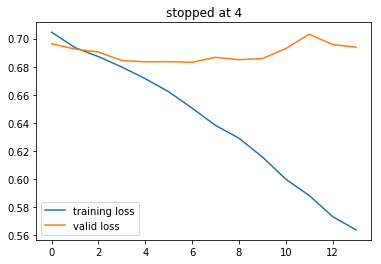

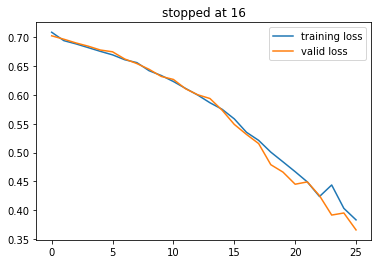

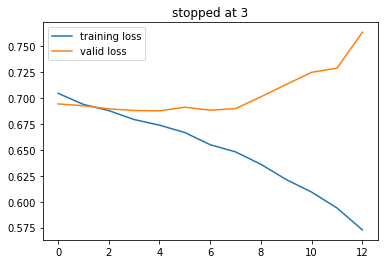

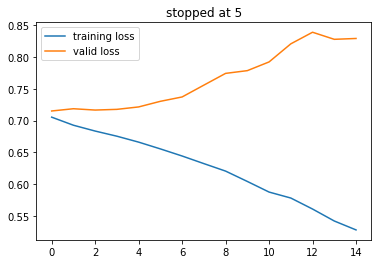

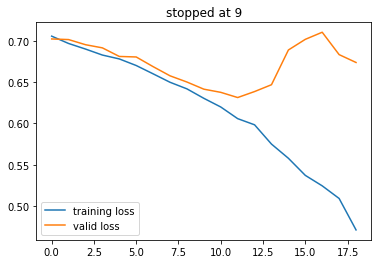

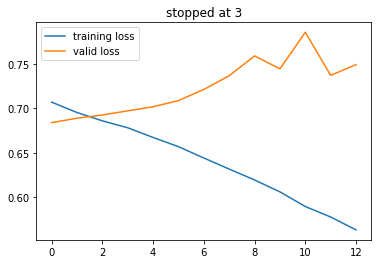

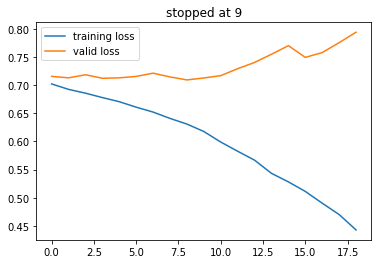

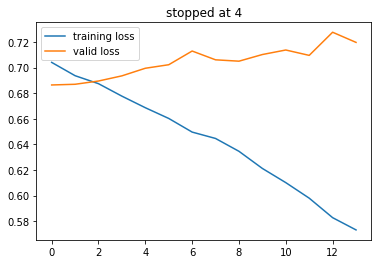

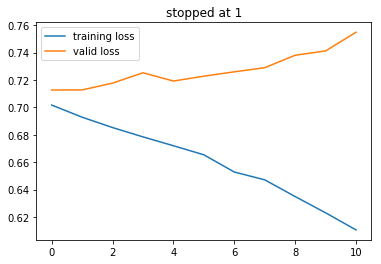

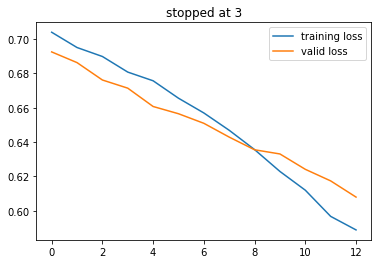

In [179]:
for i in range(10):
    plt.figure()
    plt.title("stopped at "+str(len(fold_train_metrics[i])-patience))
    plt.plot(np.asarray(fold_train_metrics[i])[:,0],label="training loss")
    plt.plot(np.asarray(fold_valid_metrics[i])[:,0],label="valid loss")
    plt.legend()

##### Regularizing with carry over seems to help with overfitting
But the "specificity boost" is even stronger

task	|dowsampling factor |learning_rate |hidden_size|num_layers|bidirectional|carry over | dropout| gradient clipping| early stopped 
--|--|--|--|--|--|--|--|--|--
spirals | 1 | 0.001 | 10 | 2 | True |0.1| 0.5 | 5.0 | 5.00 (+ 4.49) 

![carry_over](carry_over.png)

##### 3 layers gives better results and prevents overfitting
and reverses the "specificity boost" 

task	|dowsampling factor |learning_rate |hidden_size|num_layers|bidirectional|carry over | dropout| gradient clipping| early stopped 
--|--|--|--|--|--|--|--|--|--
spirals | 1 | 0.001 | 10 | 3 | True |0 | 0.5 | 5.0 | 4.90 (+ 4.01)

![3layers](3layers.png)

##### Using more units per layer gives better results but more overfitting and variance

task	|dowsampling factor |learning_rate |hidden_size|num_layers|bidirectional|dropout| gradient clipping| early stopped 
--|--|--|--|--|--|--|--|--
spirals | 1 | 0.001 | 100 | 1 | True | 0.5 | 5.0 | 5.00 (+ 4.49) 

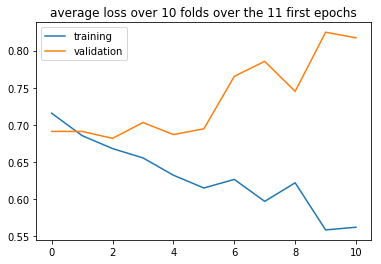

In [87]:
plt.figure()
plt.title("average loss over 10 folds over the {} first epochs".format(shortest_fold))
plt.plot(avg_train[:,0],label="training")
plt.plot(avg_valid[:,0],label="validation")
plt.legend()

##### With 2 layers the effect is augmented (even more with 3)
task	|dowsampling factor |learning_rate |hidden_size|num_layers|bidirectional|dropout| gradient clipping| early stopped 
--|--|--|--|--|--|--|--|--
spiral | 1 | 0.001 | 100 | 2 | True | 0.5 | 5.0 | 4.70 (+ 4.00) 

![2layers.png](2layers.png)

##### The model doesn't behave the same way with the l task
task	|dowsampling factor |learning_rate |hidden_size|num_layers|bidirectional|dropout| gradient clipping| early stopped 
--|--|--|--|--|--|--|--|--
l | 1 | 0.001 | 10 | 2 | True | 0.5 | 5.0 | 4.70 (+ 4.31)

l | 1 | 0.001 | 10 | 2 | True | 0.5 | 5.0 | 4.70 (+ 4.31)


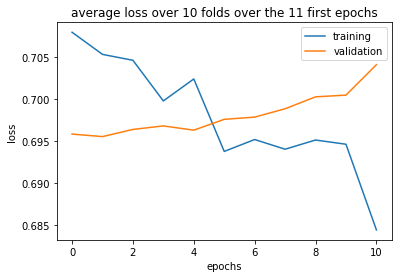

In [105]:
print(results[0:57].replace(";","|"))
plt.figure()
plt.title("average loss over 10 folds over the {} first epochs".format(shortest_fold))
plt.plot(avg_train[:,0],label="training")
plt.plot(avg_valid[:,0],label="validation")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()

## Accuracy

 learning_rate |hidden_size|num_layers|bidirectional|dropout| gradient clipping| early stopped | TRAIN accuracy | accuracy | Se | Sp | PPV | NPV
--|--|--|--|--|--|--|--|--|--|--|--|--
**0.0001** | 100 | 1 | True | 0.0 | 5.0 | 14.80 (+ 12.37) | 0.63 (+ 0.09) | 0.71 (+ 0.09) | 0.55 (+ 0.27) | 0.87 (+ 0.18) | 0.88 (+ 0.15) | 0.70 (+ 0.16) 

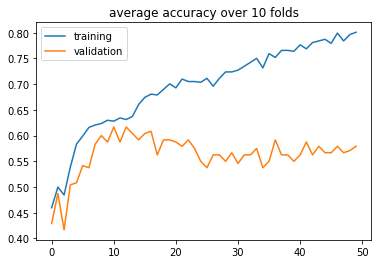

In [104]:
plt.figure()
plt.title("average accuracy over 10 folds")
plt.plot(avg_train[:,1],label="training")
plt.plot(avg_valid[:,1],label="validation")
plt.legend()

 learning_rate |hidden_size|num_layers|bidirectional|dropout| gradient clipping| early stopped | TRAIN accuracy | accuracy | Se | Sp | PPV | NPV
--|--|--|--|--|--|--|--|--|--|--|--|--
0.001 | **10** | 1 | True | 0.0 | 5.0 | 5.70 (+ 4.22) | 0.59 (+ 0.06) | 0.67 (+ 0.11) | 0.83 (+ 0.20) | 0.51 (+ 0.25) | 0.65 (+ 0.14) | 0.74 (+ 0.30)

The model seems to overfit less than usual, this is probably because it has way less parameters (~1.5k instead of ~43k)

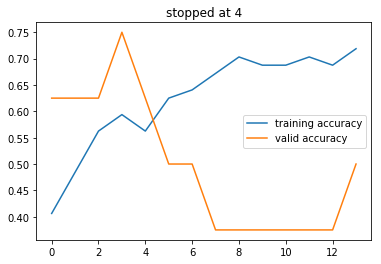

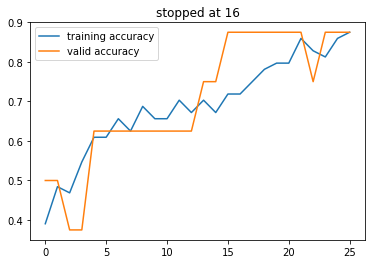

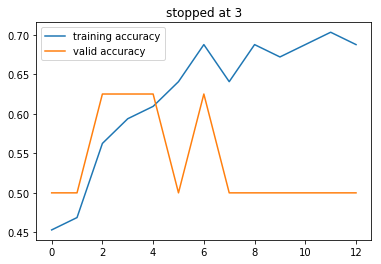

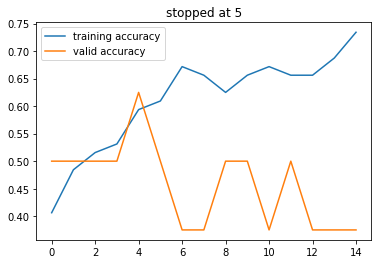

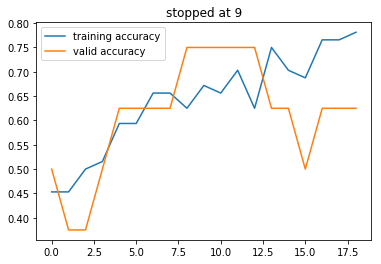

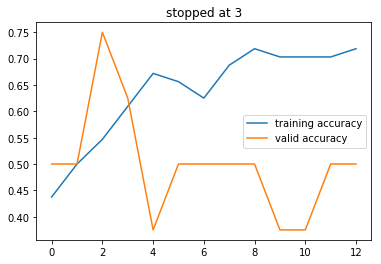

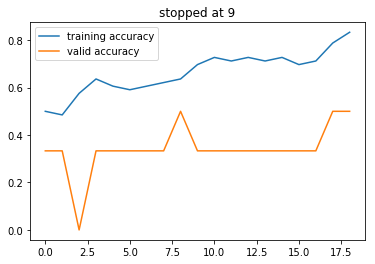

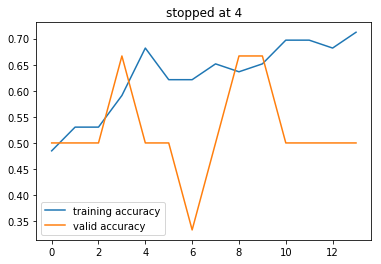

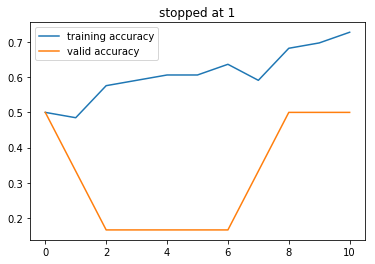

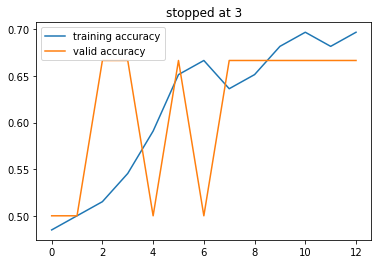

In [180]:
for i in range(10):
    plt.figure()
    plt.title("stopped at "+str(len(fold_train_metrics[i])-patience))
    plt.plot(np.asarray(fold_train_metrics[i])[:,1],label="training accuracy")
    plt.plot(np.asarray(fold_valid_metrics[i])[:,1],label="valid accuracy")
    plt.legend()

##  Interpretation

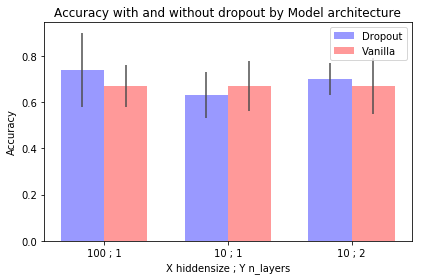

In [138]:
n_groups = 3

"""0.74	0.16
0.63	0.1
0.7	0.07
"""
accuracy_with_dropout = (0.74, 0.63, 0.7)
std_with_dropout = (0.16, 0.1, 0.07)

accuracy_vanilla = (0.67, 0.67, 0.67)
std_vanilla = (0.09, 0.11, 0.12)

"""0.67	0.09
0.67	0.11
0.67	0.12"""

fig, ax = plt.subplots()

index = np.arange(n_groups)
bar_width = 0.35

opacity = 0.4
error_config = {'ecolor': '0.3'}

rects1 = ax.bar(index, accuracy_with_dropout, bar_width,
                alpha=opacity, color='b',
                yerr=std_with_dropout, error_kw=error_config,
                label='Dropout')

rects2 = ax.bar(index + bar_width, accuracy_vanilla, bar_width,
                alpha=opacity, color='r',
                yerr=std_vanilla, error_kw=error_config,
                label='Vanilla')

ax.set_xlabel('X hiddensize ; Y n_layers')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy with and without dropout by Model architecture')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(('100 ; 1', '10 ; 1', '10 ; 2'))
ax.legend()

fig.tight_layout()
plt.show()

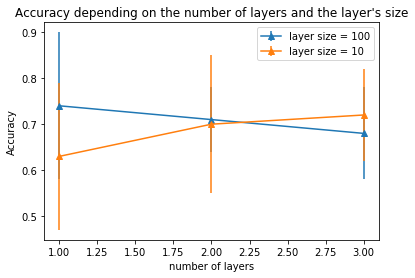

In [146]:
plt.figure()


plt.title("Accuracy depending on the number of layers and the layer's size")
plt.errorbar(range(1,4),[0.74,0.71,0.68],[0.16,0.07,0.1],label="layer size = 100", marker='^')
plt.errorbar(range(1,4),[0.63,0.7,0.72],[0.16,0.15,0.1],label="layer size = 10", marker='^')
plt.xlabel("number of layers")
plt.ylabel("Accuracy")
plt.legend()

## Model weights

In [596]:
fold_train_metrics[0]

[[0.7049412904307246, 0.53125, 0.1875, 0.875, 0.6, 0.5185185185185185]]

In [533]:
generator = model.modules()
print(next(generator))
lstm=next(generator)

Model(
  (encoder): LSTM(7, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [539]:
print("""the learnable input-hidden weights of the kth layer (W_ii|W_if|W_ig|W_io) (with k=0 in our case),
of shape (4*hidden_size x input_size)""")
print(lstm.weight_ih_l0.shape)
input_weights=lstm.weight_ih_l0.cpu().detach().numpy()

the learnable input-hidden weights of the kth layer (W_ii|W_if|W_ig|W_io) (with k=0 in our case),
of shape (4*hidden_size x input_size)
torch.Size([400, 7])


#### Biases after init at 1


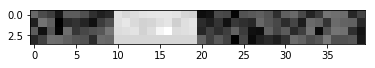

In [358]:
biases=[lstm.bias_hh_l0,
lstm.bias_hh_l0_reverse,
lstm.bias_hh_l1,
lstm.bias_hh_l1_reverse]
for i,b in enumerate(biases):
    biases[i]=b.cpu().detach().numpy()
plt.imshow(biases,cmap='gray')